## IMDb Movie Review Sentiment Analysis

### Problem Statement
The main aim of this project is to create a machine learning classification model that can determine the sentiment of IMDb movie reviews. The dataset includes a collection of reviews, each labeled as either positive or negative.

Through text preprocessing and feature extraction methods (such as TF-IDF), the project focuses on converting raw reviews into numerical features. Different classification algorithms will be applied to build a model that can effectively identify the sentiment expressed in the reviews.

The model’s performance will be measured using common evaluation metrics, including accuracy, precision, recall, and F1-score.

In [1]:
## Importing the libraries which will be usefull for our analysis
import pandas as pd

## Loading the dataset
df = pd.read_csv("Imdb.csv")

### 1. Data Exploration and Preprocessing

In [2]:
## Basic exploration
df.head()   # View first few rows

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
df.info()  # Data types and missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [4]:
df['sentiment'].value_counts()   # Check class balance (positive vs negative)

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [5]:
## Check for missing values
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [6]:
## Analyze review lengths
df['review_length'] = df['review'].apply(len)
df['review_length'].describe()  # Stats: mean, min, max length

count    50000.000000
mean      1309.367720
std        989.759532
min          7.000000
25%        699.000000
50%        970.000000
75%       1590.000000
max      13704.000000
Name: review_length, dtype: float64

In [7]:
## Identify outliers (e.g., very short or long reviews)
outliers = df[(df['review_length'] < 50) | (df['review_length'] > 5000)]
print(outliers)

                                                  review sentiment  \
156    From the film's first shot - Keira Knightley a...  negative   
263    There is a difference between a "film," and a ...  negative   
310    Some people drift through life, moving from on...  positive   
320    "Quitting" may be as much about exiting a pre-...  positive   
365    Years ago, when DARLING LILI played on TV, it ...  negative   
...                                                  ...       ...   
49772  CitizenX(1995) is the developing world's answe...  positive   
49792  Thirty years after its initial release, the th...  positive   
49833  THE SHOP AROUND THE CORNER is one of the sweet...  positive   
49861  OK OK, it might be hard to put the entirety of...  negative   
49948  It is the early morning of our discontent, and...  negative   

       review_length  
156             5254  
263             5101  
310             5862  
320             5552  
365             5700  
...              ... 

In [8]:
## Text Preprocessing

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [9]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    ## Remove HTML tags and special characters
    text = re.sub(r'<.*?>', '', text)  # Remove <br /> etc.
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    ## Tokenize
    tokens = word_tokenize(text.lower())     # Split text into words (tokens) and convert to lowercase
    ## Remove stop words
    tokens = [word for word in tokens if word not in stop_words]     # Remove stopwords (e.g. in, the, and)
    ## Stemming and Lemmatization
    stemmed = [stemmer.stem(word) for word in tokens]
    lemmatized = [lemmatizer.lemmatize(word) for word in stemmed]       # reducing words to their base forms
    return ' '.join(lemmatized)

df['cleaned_review'] = df['review'].apply(preprocess_text)
df['cleaned_review'].head()

0    one review mention watch 1 oz episod youll hoo...
1    wonder littl product film techniqu unassum old...
2    thought wonder way spend time hot summer weeke...
3    basic there famili littl boy jake think there ...
4    petter mattei love time money visual stun film...
Name: cleaned_review, dtype: object

### 2. Feature Engineering
Vectorize text using TF-IDF. Add textual features like word count, character count, average word length.

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
import numpy as np

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)  # Limit to top 5000 features
X_tfidf = tfidf.fit_transform(df['cleaned_review'])

# Additional textual features
df['word_count'] = df['cleaned_review'].apply(lambda x: len(x.split()))      # Counts the number of words in each review.
df['char_count'] = df['cleaned_review'].apply(len)                           # Counts total characters (including spaces).
df['avg_word_length'] = df['char_count'] / df['word_count']                  # Average characters per word.

### 3. Model Development
Here we are going to encode labels as (positive=1, negative=0). Split data, train models like Logistic Regression, Naive Bayes, SVM, Random Forest. For neural networks, use LSTM.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [12]:
## Encode sentiment
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})
# Here we perform sentiment label encoding, converting text-based sentiment labels ('positive' and 'negative') into numerical values (1 and 0)

In [13]:
## Split data (using TF-IDF features)
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf,          # TF-IDF features (sparse matrix)
    df['label'],      # Numerical labels (0 or 1)
    test_size=0.2,    # 20% of data for testing
    random_state=42   # Ensures reproducibility
)

In [14]:
## Logistic Regression
lr = LogisticRegression()         # Its a linear model ideal for binary classification (like our case of 0/1 sentiment labels).
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [15]:
## Naive Bayes
nb = MultinomialNB()    # We have used multinomialNB because its designed for discrete data and text classification tasks
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

In [16]:
## SVM
svm = SVC(kernel='linear')     # linear kernel is ideal for text data 
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

In [17]:
## Random Forest      
# Initialize Random Forest classifier with 100 decision trees n_estimators=100 creates an ensemble of 100 individual decision trees
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [20]:
## Neural Network (LSTM with embeddings):


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

## Tokenize for LSTM
#Initialize a Tokenizer to convert words to integers, num_words=5000 keeps only the top 5000 most frequent words
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['cleaned_review'])
# Convert the text reviews to sequences of integer indices each word is replaced by its corresponding integer from the tokenizer
sequences = tokenizer.texts_to_sequences(df['cleaned_review'])  
X_padded = pad_sequences(sequences, maxlen=200)    # Pad/truncate sequences to ensure uniform length (200 tokens)

## Split
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X_padded, df['label'], test_size=0.2, random_state=42)

## LSTM Model
model = Sequential()     # Initialize a sequential model (linear stack of layers)
model.add(Embedding(input_dim=5000, output_dim=128))    
# input_dim=5000: Vocabulary size (top 5000 words)
# output_dim=128: Each word represented as 128-dimensional vector

model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))   
# 128 units: Dimensionality of output space
# dropout=0.2: Randomly drop 20% of input units to prevent overfitting
# recurrent_dropout=0.2: Drop 20% of recurrent connections

model.add(Dense(1, activation='sigmoid'))
# Final dense layer with sigmoid activation for binary classification
# Outputs probability between 0-1 (1 neuron for binary classification)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Configure model training process
# loss='binary_crossentropy': Standard for binary classification
# optimizer='adam': Adaptive learning rate optimizer
# metrics=['accuracy']: Track accuracy during training

model.fit(X_train_nn, y_train_nn, epochs=5, batch_size=32, validation_split=0.2)
# X_train_nn: Padded sequences of integers
# y_train_nn: Binary labels (0 or 1)
# epochs=5: Process entire dataset 5 times
# batch_size=32: Number of samples per gradient update
# validation_split=0.2: Use 20% of training data for validation

y_pred_nn = (model.predict(X_test_nn) > 0.5).astype(int)

Epoch 1/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 145s 143ms/step - accuracy: 0.8276 - loss: 0.3970 - val_accuracy: 0.8620 - val_loss: 0.3249
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 131s 131ms/step - accuracy: 0.8824 - loss: 0.2956 - val_accuracy: 0.8689 - val_loss: 0.3378
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 129s 129ms/step - accuracy: 0.8900 - loss: 0.2731 - val_accuracy: 0.8741 - val_loss: 0.3111
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 141s 141ms/step - accuracy: 0.9211 - loss: 0.2066 - val_accuracy: 0.8670 - val_loss: 0.3120
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 142s 142ms/step - accuracy: 0.9348 - loss: 0.1733 - val_accuracy: 0.8705 - val_loss: 0.3261
313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step


### 4. Model Evaluation

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return acc, prec, rec, f1

In [22]:
## Evaluation for Logistic Regression
acc_lr, prec_lr, rec_lr, f1_lr = evaluate_model(y_test, y_pred_lr)
# Accuracy (acc_lr): Overall correctness of predictions
# Precision (prec_lr): When predicting positive, how often correct (avoid false positives)
# Recall (rec_lr): How many actual positives were found (avoid false negatives)
# F1-score (f1_lr): Harmonic mean of precision and recall

print(f"Logistic Regression: Acc={acc_lr:.2f}, Prec={prec_lr:.2f}, Rec={rec_lr:.2f}, F1={f1_lr:.2f}")

Logistic Regression: Acc=0.89, Prec=0.88, Rec=0.90, F1=0.89


In [23]:
## Evaluation for Naive Bayes
acc_nb, prec_nb, rec_nb, f1_nb = evaluate_model(y_test, y_pred_nb)
print(f"Naive Bayes: Acc={acc_nb:.2f}, Prec={prec_nb:.2f}, Rec={rec_nb:.2f}, F1={f1_nb:.2f}")

Naive Bayes: Acc=0.85, Prec=0.84, Rec=0.86, F1=0.85


In [24]:
## Evaluation for SVM
acc_svm, prec_svm, rec_svm, f1_svm = evaluate_model(y_test, y_pred_svm)
print(f"SVM: Acc={acc_svm:.2f}, Prec={prec_svm:.2f}, Rec={rec_svm:.2f}, F1={f1_svm:.2f}")

SVM: Acc=0.89, Prec=0.88, Rec=0.90, F1=0.89


In [25]:
## Evaluation for Random Forest
acc_rf, prec_rf, rec_rf, f1_rf = evaluate_model(y_test, y_pred_rf)
print(f"Random Forest: Acc={acc_rf:.2f}, Prec={prec_rf:.2f}, Rec={rec_rf:.2f}, F1={f1_rf:.2f}")

Random Forest: Acc=0.84, Prec=0.85, Rec=0.83, F1=0.84


In [26]:
## Evaluation for Neural Network (LSTM)
acc_nn, prec_nn, rec_nn, f1_nn = evaluate_model(y_test, y_pred_nn)
print(f"Neural Network (LSTM): Acc={acc_nn:.2f}, Prec={prec_nn:.2f}, Rec={rec_nn:.2f}, F1={f1_nn:.2f}")

Neural Network (LSTM): Acc=0.88, Prec=0.88, Rec=0.87, F1=0.88


### 5. Final Report and Presentation

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud

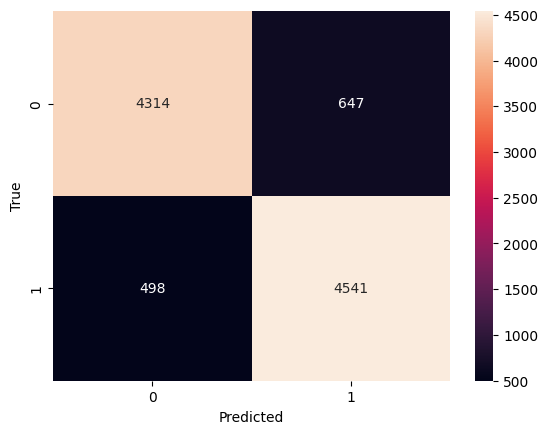

In [28]:
# Confusion Matrix Plot for LR
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Key Findings and Insights

Word clouds revealed positive reviews often used words like 'great', 'love', and 'amazing', while negatives had 'bad', 'boring', and 'waste'.

Review length influenced sentiment—longer reviews tended to be more negative. 

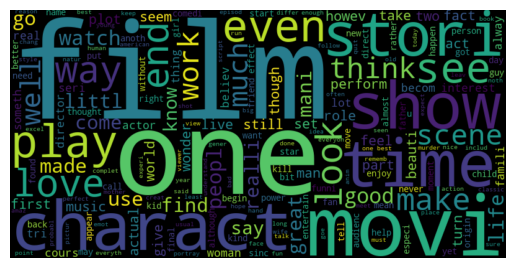

In [29]:
# Word Cloud for positive reviews
positive_text = ' '.join(df[df['label'] == 1]['cleaned_review'])
wordcloud = WordCloud(width=800, height=400).generate(positive_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

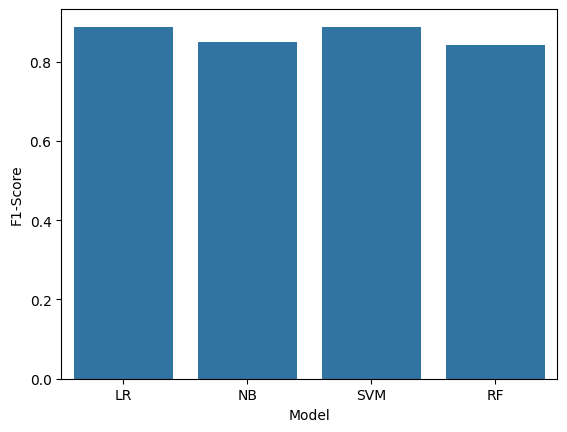

In [30]:
# Bar chart of metrics
metrics = {'Model': ['LR', 'NB', 'SVM', 'RF'], 'F1-Score': [f1_lr, f1_nb, f1_svm, f1_rf]}
metrics_df = pd.DataFrame(metrics)
sns.barplot(x='Model', y='F1-Score', data=metrics_df)
plt.show()

### Video URL
https://drive.google.com/file/d/1-S397nn8G0wIBu3XX1IpX2VjIJqLmqCZ/view?usp=sharing